# Smart Charging Using Reinforcement Learning

In [115]:
import math
import numpy as np
import gym
from gym import Env
from gym.spaces import Discrete, Box
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

## Electric Vehicle Charging Environment
We start by creating the environment for simulating electric vehicle (EV) charging using the OpenAI Gym framework. The environment defines a Markov decision process, including states, actions and a reward function with different charging rates and time-dependent energy prices.

### Key Components

- `action_space`: The environment offers four charging actions: no charge, low, medium, and high charging.

- `battery_limit`: Represents the EV's battery capacity, assumed to be 100 kWh.

- `battery_level`: Initialized to the battery's full capacity at the start.

- `observation_space`: A state consists of the battery level and the current time interval.

- `current_time_index`: Tracks the time interval (0-7) for charging intervals.

- `time_coefficients`: Coefficients representing volatile energy prices from 2pm to 4pm ranging from 47$/MWh to 50$/MWh or 0.94 to 1. (Source: https://www.researchgate.net/profile/Torjus-Bolkesjo/publication/310021998/figure/fig3/AS:431952714047493@1479996960479/Hourly-intra-day-variation-of-the-electricity-price-for-Germany-in-MWh-and-the.png)

- `charging_rates`: Charging rates for different actions (0, 1.75, 3.5, 5.5 kWh).

### Functions

- `step(action)`: Simulates one time step in the environment. The agent's action determines the charging rate, and the environment updates the battery level, calculates rewards based on energy prices, and applies penalties for insufficient battery levels.

- `reset()`: Resets the environment to the initial state, including battery level and time.

### Objective

The agent's objective is to make charging decisions that minimize costs, considering time of day and charging rate. By interacting with this environment, the agent can learn strategies to optimize the charging process and manage the EV's battery effectively.


#### Calculate time coefficients
We understand the time coefficient as factor representing the volatility in energy prices. Therefore, we create a list of 8 time coefficients, each representing the proportion of the highest price in the given period. We observed the baseline prices from the platform https://www.iea.org/data-and-statistics/data-tools/real-time-electricity-tracker. The application yielded the following results for the period from 15/07/2023 to 14/08/2023 (only weekdays):
- 2pm: 43.40 $/MWh
- 3pm: 45.03 $/MWh
- 4pm: 48.49 $/MWh

In [116]:
# Given range of prices
min_price = 43.4
max_price = 48.49

num_coefficients = 8

# Generate time coefficients using linear interpolation
time_coefficients = np.linspace(min_price / max_price, 1.0, num=num_coefficients)

# Round the time coefficients to two decimals
time_coefficients = [round(coeff, 2) for coeff in time_coefficients]

print(time_coefficients)

[0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]


In [117]:
class EVChargingEnvironment(Env):
    def __init__(self):
        self.action_space = Discrete(NUM_ACTIONS)
        self.battery_limit = BATTERY_LIMIT
        self.battery_level = self.battery_limit

        # A state in the environment consists of battery level (0-100 kWh) and time interval (0-7) 
        self.observation_space = np.array([Box(low=np.array([0.0]), high=np.array([self.battery_limit])), Discrete(NUM_TIME_INTERVALS)])

        # Initialize first state
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index])

        # Set time coefficient as defined above
        self.time_coefficients = [0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]

        # Charging rates in range 0, 7, 14, 22 kWh divided by 4 (because we charge only 15 minutes)
        self.charging_rates = [0.0, 1.75, 3.5, 5.5]

    def _calculate_reward(self, charging_rate):
        time_coefficient_multiplier = self.time_coefficients[self.current_time_index]
        reward = time_coefficient_multiplier * math.exp(charging_rate) * (-1) 
        if charging_rate == 0:
            reward = 0
        return reward

    def step(self, action):

        self.state[1] = self.current_time_index
        charging_rate = self.charging_rates[action]
        
        if self.battery_level + charging_rate > self.battery_limit:
            charging_rate = self.battery_limit - self.battery_level
        
        self.battery_level += charging_rate
        self.state[0] = self.battery_level

        reward = self._calculate_reward(charging_rate)

        # Update time index
        self.current_time_index = (self.current_time_index + 1) % NUM_TIME_INTERVALS

        # Check if simulation is complete
        done = self.current_time_index == 0

        if done:
            # Get energy demand from normal distribution
            energy_demand = np.random.normal(30.0, 5.0)

            # Set new battery level
            self.battery_level = self.battery_level - energy_demand

            if self.battery_level < 0.0:
                # We set a very high penalty of 10,000 because of the cost function resulting in high costs
                reward -= 10000.0
                # Set battery level to zero
                self.battery_level = 0.0
                self.state[0] = self.battery_level

        return self.state, reward, done, {}

    def reset(self):
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index])
        return self.state

In [118]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1, 2)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, nb_actions=actions, nb_steps_warmup=10000, target_model_update=1e-2)
    return dqn

In [119]:
NUM_ACTIONS = 4 # Action space contains 4 actions: zero, low, medium, high charging
NUM_TIME_INTERVALS = 8 # charging every 15 minutes from 2pm to 4pm
BATTERY_LIMIT = 58.0 # Assumption: 58 kWh (Netto) battery capacity

env = EVChargingEnvironment()

### Explore Environment

In [120]:
episodes = 5

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward

        print(f"Action: {action} | New State: {n_state} | Reward: {reward} | Done: {done}")
    
    print(f"Episode {episode} - Score: {score}\n{'*' * 50}")


Episode 1
Initial State: [58.  0.]
Action: 3 | New State: [58.  0.] | Reward: 0 | Done: False
Action: 2 | New State: [58.  1.] | Reward: 0 | Done: False
Action: 2 | New State: [58.  2.] | Reward: 0 | Done: False
Action: 1 | New State: [58.  3.] | Reward: 0 | Done: False
Action: 2 | New State: [58.  4.] | Reward: 0 | Done: False
Action: 3 | New State: [58.  5.] | Reward: 0 | Done: False
Action: 3 | New State: [58.  6.] | Reward: 0 | Done: False
Action: 0 | New State: [58.  7.] | Reward: 0 | Done: True
Episode 1 - Score: 0
**************************************************
Episode 2
Initial State: [38.92563441  0.        ]
Action: 2 | New State: [42.42563441  0.        ] | Reward: -29.803906762823082 | Done: False
Action: 1 | New State: [44.17563441  1.        ] | Reward: -5.236688435165215 | Done: False
Action: 1 | New State: [45.92563441  2.        ] | Reward: -5.35178048868533 | Done: False
Action: 1 | New State: [47.67563441  3.        ] | Reward: -5.409326515445387 | Done: False
Act

Here we can see that the agent does not charge and has no costs when the battery is fully charged. After one episode the energy demand is subtracted and the new battery level is 32.49 kWh. In the next episode the agent charges with charging rates 1.75 + 3.5 + 3.5 + 1.75 + 1.75 + 3.5 = 48.24. We can see that the charging rates are added correctly. Also the rewards are correct, e.g. for the second step: 0.91*e^3.5 *(-1) = 30.14 

## Deep Q-Network using Keras

In the next step we create a deep Q-Network for approximating the Q-values in our environment. With Q-Learning we are able to learn about the greedy policy, while using a different behaviour policy for acting in the environment. The behaviour policy is usually an $\epsilon$-greedy policy, that selects the greedy action with probability 1 - $\epsilon$ and a random action with probability $\epsilon$ to ensure good coverage of the state-action space.

In [121]:
# Get shpaes of states and actions from our environment
states = env.observation_space.shape
actions = env.action_space.n

# Train the deep q-network with 500,000 steps
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
training_results = dqn.fit(env, nb_steps=1000000, visualize=False, verbose=1)

2023-08-14 18:18:46.962194: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_50_1/kernel/Assign' id:7431 op device:{requested: '', assigned: ''} def:{{{node dense_50_1/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_50_1/kernel, dense_50_1/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training for 1000000 steps ...
Interval 1 (0 steps performed)


2023-08-14 18:18:47.703422: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_50/BiasAdd' id:7367 op device:{requested: '', assigned: ''} def:{{{node dense_50/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_50/MatMul, dense_50/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-14 18:18:47.898102: W tensorflow/c/c_api.cc:304] Operation '{name:'total_64/Assign' id:7570 op device:{requested: '', assigned: ''} def:{{{node total_64/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_64, total_64/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after runni

10000/10000 [==============================] - 25s 2ms/step - reward: -930.8736
1250 episodes - episode_reward: -7446.989 [-11220.842, -96.541]

Interval 2 (10000 steps performed)
    1/10000 [..............................] - ETA: 59s - reward: -220.2227

2023-08-14 18:19:12.979645: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_50_1/BiasAdd' id:7441 op device:{requested: '', assigned: ''} def:{{{node dense_50_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_50_1/MatMul, dense_50_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-14 18:19:13.503193: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_67/AddN' id:7701 op device:{requested: '', assigned: ''} def:{{{node loss_67/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_67/mul, loss_67/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-

10000/10000 [==============================] - 181s 18ms/step - reward: -1129.9658
1250 episodes - episode_reward: -9039.726 [-11178.057, -70.085] - loss: 1951100.999 - mae: 4301.335 - mean_q: -5106.385

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 174s 17ms/step - reward: -1133.5027
1250 episodes - episode_reward: -9068.022 [-11219.007, -169.384] - loss: 837893.188 - mae: 4802.471 - mean_q: -5781.257

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 142s 14ms/step - reward: -776.5652
1250 episodes - episode_reward: -6212.521 [-11400.096, -112.666] - loss: 747080.062 - mae: 4471.716 - mean_q: -5253.607

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 145s 14ms/step - reward: -1116.6465
1250 episodes - episode_reward: -8933.172 [-11394.744, -268.549] - loss: 686787.188 - mae: 4125.594 - mean_q: -4760.272

Interval 6 (50000 steps performed)
10000/10000 [==============================] 

In [ ]:
save training results
import pickle as pickle
with open('./data/rl/trainHistoryDict_1_000_000_steps', 'wb') as file_pi:
    pickle.dump(training_results.history, file_pi)

dqn.save_weights('./data/rl/dqn_weights_1_000_000_steps.hdf5', overwrite=True)

When we look at the cumulative rewards after training the DQNAgent, we can see that our agent does not improve its performance after about 15,000 episodes.

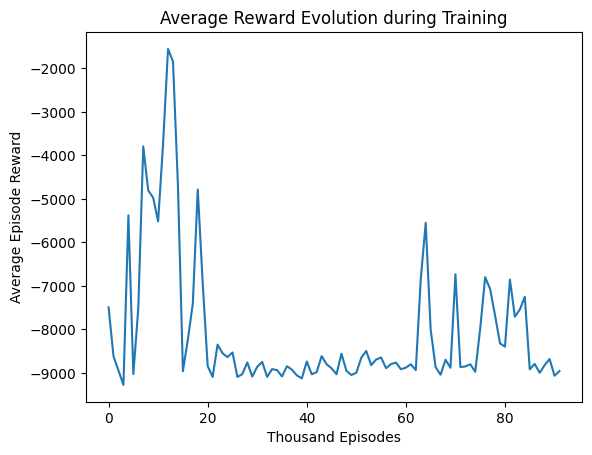

In [123]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rewards is your list of rewards

# Calculate the average rewards for every 1000 episodes
avg_rewards = [np.mean(rewards[i:i+1000]) for i in range(0, len(rewards), 1000)]

# Plot the average rewards
plt.plot(avg_rewards)
plt.xlabel('Thousand Episodes')
plt.ylabel('Average Episode Reward')
plt.title('Average Reward Evolution during Training')
plt.show()


So let us zoom in.

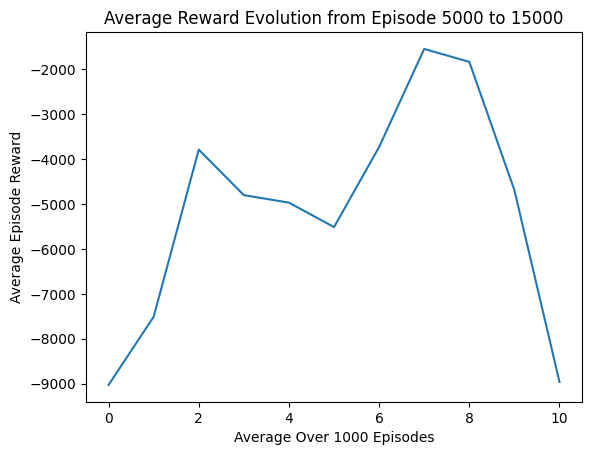

In [126]:
# Assuming rewards is your list of rewards
start_episode = 5000
end_episode = 15000
window_size = 1000  # Number of episodes in each rolling average window

# Calculate the average rewards for the specified episode range
avg_rewards_range = [np.mean(rewards[i:i+window_size]) for i in range(start_episode, end_episode+1, window_size)]

# Plot the average rewards for the specified episode range
plt.plot(avg_rewards_range)
plt.xlabel(f"Average Over {window_size} Episodes")
plt.ylabel('Average Episode Reward')
plt.title(f'Average Reward Evolution from Episode {start_episode} to {end_episode}')
plt.show()


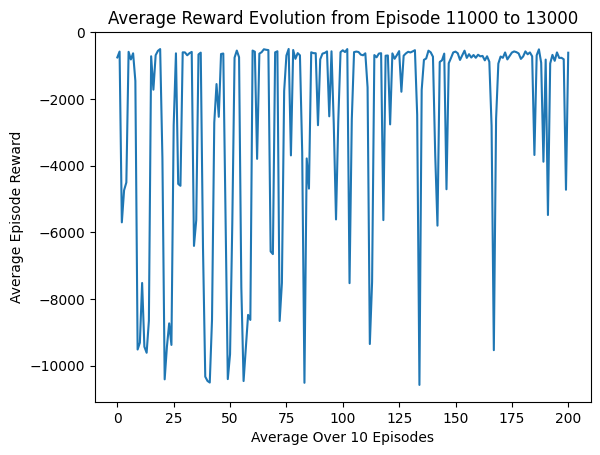

In [129]:
start_episode = 11000
end_episode = 13000
window_size = 10  # Number of episodes in each rolling average window

# Calculate the average rewards for the specified episode range
avg_rewards_range = [np.mean(rewards[i:i+window_size]) for i in range(start_episode, end_episode+1, window_size)]

# Plot the average rewards for the specified episode range
plt.plot(avg_rewards_range)
plt.xlabel(f"Average Over {window_size} Episodes")
plt.ylabel('Average Episode Reward')
plt.title(f'Average Reward Evolution from Episode {start_episode} to {end_episode}')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming rewards is your list of rewards

# Calculate the average rewards for every 1000 episodes
avg_rewards = [np.mean(rewards[i:i+1000]) for i in range(0, len(rewards), 1000)]

# Plot the average rewards
plt.plot(avg_rewards)
plt.xlabel('Thousand Episodes')
plt.ylabel('Average Episode Reward')
plt.title('Average Reward Evolution during Training')
plt.show()


Here we can see how our agent receives penalties for running out of energy. Through the $\epsilon$-greedy policy, the agent chooses random actions with $\epsilon$ probability and therefor has the risk to select too little charging rates.

Let's look at our trained policy now.

In [ ]:
num_episodes = 1000

for episode in range(num_episodes):
    learned_policy = []
    scores = 0
    state = env.reset()
    done = False


    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        scores += reward
    if episode % 100 == 0:
        print(f"Episode {episode + 1}: Final battery level: {state[0]}") 
        print(f"Episode {episode + 1}: Learned Policy: {learned_policy}")
        print(f"Episode {episode + 1}: Score: {scores}")

Episode 1: Final battery level: 0.0
Episode 1: Learned Policy: [0, 0, 2, 1, 1, 1, 1, 1]
Episode 1: Score: -10058.764739326973


Episode 101: Final battery level: 0.0
Episode 101: Learned Policy: [0, 0, 2, 1, 1, 1, 1, 1]
Episode 101: Score: -10058.764739326973
Episode 201: Final battery level: 0.0
Episode 201: Learned Policy: [0, 0, 2, 1, 1, 1, 1, 1]
Episode 201: Score: -10058.764739326973


KeyboardInterrupt: 

Here we can see, that our agent has learned a constant charging behavior of low charging over the whole period. The agents seems to maintain a level of aro

## Electric Vehicle Charging Environment
We start by creating the environment for simulating electric vehicle (EV) charging using the OpenAI Gym framework. The environment defines a Markov decision process, including states, actions and a reward function with different charging rates and time-dependent energy prices.

### Key Components

- `action_space`: The environment offers four charging actions: no charge, low, medium, and high charging.

- `battery_limit`: Represents the EV's battery capacity, assumed to be 100 kWh.

- `battery_level`: Initialized to the battery's full capacity at the start.

- `observation_space`: A state consists of the battery level and the current time interval.

- `current_time_index`: Tracks the time interval (0-7) for charging intervals.

- `time_coefficients`: Coefficients representing volatile energy prices from 2pm to 4pm ranging from 47$/MWh to 50$/MWh or 0.94 to 1. (Source: https://www.researchgate.net/profile/Torjus-Bolkesjo/publication/310021998/figure/fig3/AS:431952714047493@1479996960479/Hourly-intra-day-variation-of-the-electricity-price-for-Germany-in-MWh-and-the.png)

- `charging_rates`: Charging rates for different actions (0, 1.75, 3.5, 5.5 kWh).

### Functions

- `step(action)`: Simulates one time step in the environment. The agent's action determines the charging rate, and the environment updates the battery level, calculates rewards based on energy prices, and applies penalties for insufficient battery levels.

- `reset()`: Resets the environment to the initial state, including battery level and time.

### Objective

The agent's objective is to make charging decisions that minimize costs, considering time of day and charging rate. By interacting with this environment, the agent can learn strategies to optimize the charging process and manage the EV's battery effectively.


#### Calculate time coefficients
We understand the time coefficient as factor representing the volatility in energy prices. Therefore, we create a list of 8 time coefficients, each representing the proportion of the highest price in the given period. We observed the baseline prices from the platform https://www.iea.org/data-and-statistics/data-tools/real-time-electricity-tracker. The application yielded the following results for the period from 15/07/2023 to 14/08/2023 (only weekdays):
- 2pm: 43.40 $/MWh
- 3pm: 45.03 $/MWh
- 4pm: 48.49 $/MWh

In [ ]:
# Given range of prices
min_price = 43.4
max_price = 48.49

num_coefficients = 8

# Generate time coefficients using linear interpolation
time_coefficients = np.linspace(min_price / max_price, 1.0, num=num_coefficients)

# Round the time coefficients to two decimals
time_coefficients = [round(coeff, 2) for coeff in time_coefficients]

print(time_coefficients)

[0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]


#### Definition of environment

In [ ]:
class EVChargingEnvironment(Env):
    def __init__(self):
        self.action_space = Discrete(4) # Action space contains 4 actions: zero, low, medium, high charging
        self.battery_limit = 58.0 # Assumption: 58 kWh (Netto) battery capacity (VW ID.3 Pro)
        self.battery_level = self.battery_limit # Assumption: Battery fully charged at initialization

        # A state in the environment consists of battery level (0-100 kWh) and time interval (0-7) 
        self.observation_space = np.array([Box(low=np.array([0.0]), high = np.array([self.battery_limit])), Discrete(8)])

        # Initialize first state
        self.current_time_index = 0
        self.state = np.array([self.battery_level, self.current_time_index]) 

        # Given range of prices
        min_price = 37.36
        max_price = 39.92

        # Number of time coefficients you want
        num_coefficients = 8

        # Generate time coefficients using linear interpolation
        self.time_coefficients = np.linspace(min_price / max_price, 1.0, num=num_coefficients)

        # Insert pre-calculated time coefficients
        self.time_coefficients = [0.9, 0.91, 0.93, 0.94, 0.96, 0.97, 0.99, 1.0]

        # Charging rates in range 0, 7, 14, 22 kWh divided by 4 (because we charge only 15 minutes)
        self.charging_rates = [0.0, 1.75, 3.5, 5.5]

    def step(self, action):

        # Set time attribute of state to 
        self.state[1] = self.current_time_index

        # Get current time coefficient and charging rate
        time_coefficient = self.time_coefficients[self.current_time_index]
        charging_rate = self.charging_rates[action]
        
        # If the charging rate exceeds the limit, we only charge the amount of difference
        if self.battery_level + charging_rate > self.battery_limit:
            charging_rate = self.battery_limit - self.battery_level
        
        # Increase battery level
        self.battery_level += charging_rate
        self.state[0] = self.battery_level
        
        # Reward function
        reward = time_coefficient * math.exp(charging_rate) * (-1)

        # Assumption: Reward should be Zero for Zero charging
        if charging_rate == 0:
            reward = 0

        # Update time index
        self.current_time_index = (self.current_time_index + 1) % 8

        # Check if simulation is complete
        done = self.current_time_index == 0

        if done:

            # Set energy demand
            energy_demand = np.random.normal(30.0, 5.0)

            # Set new battery level
            self.battery_level = self.battery_level - energy_demand
            
            # Set penalty if battery level is too low for energy demand
            if self.battery_level < 0.0:
                # We set a very high penalty of 10,000 because of the cost function resulting in high costs
                reward -= 10000.0
                self.battery_level = 0.0 # Set Battery Level to Zero
                self.state[0] = self.battery_level

        # Setting the placeholder for info
        info = {}
        return self.state, reward, done, info

    def reset(self):

        # Set current time index to Zero
        self.current_time_index = 0

        # Initialize first state of episode
        # We use the current battery level resulting from the last episode (after demand subtraction)
        self.state = np.array([self.battery_level, self.current_time_index])

        return self.state

In [ ]:
env = EVChargingEnvironment()

/home/lukas/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


### Environment Exploration

In [ ]:
episodes = 2

for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0

    print(f"Episode {episode}\nInitial State: {state}")

    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        score += reward

        print(f"Action: {action} | New State: {n_state} | Reward: {reward} | Done: {done}")
    
    print(f"Episode {episode} - Score: {score}\n{'*' * 50}")


Episode 1
Initial State: [58.  0.]
Action: 2 | New State: [58.  0.] | Reward: 0 | Done: False
Action: 3 | New State: [58.  1.] | Reward: 0 | Done: False
Action: 1 | New State: [58.  2.] | Reward: 0 | Done: False
Action: 0 | New State: [58.  3.] | Reward: 0 | Done: False
Action: 0 | New State: [58.  4.] | Reward: 0 | Done: False
Action: 2 | New State: [58.  5.] | Reward: 0 | Done: False
Action: 1 | New State: [58.  6.] | Reward: 0 | Done: False
Action: 0 | New State: [58.  7.] | Reward: 0 | Done: True
Episode 1 - Score: 0
**************************************************
Episode 2
Initial State: [18.79451404  0.        ]
Action: 2 | New State: [22.29451404  0.        ] | Reward: -29.803906762823082 | Done: False
Action: 2 | New State: [25.79451404  1.        ] | Reward: -30.135061282410003 | Done: False
Action: 0 | New State: [25.79451404  2.        ] | Reward: 0 | Done: False
Action: 0 | New State: [25.79451404  3.        ] | Reward: 0 | Done: False
Action: 2 | New State: [29.29451404

We can see how the agent performs actions in the environment and gets the rewards. Without a learnt policy, the agent is not able to meet the energy demand. Therefore, the rewards suffer from high penalties.

## Deep Q-Network using Keras

In the next step we create a deep Q-Network for approximating the Q-values in our environment. With Q-Learning we are able to learn about the greedy policy, while using a different behaviour policy for acting in the environment. The behaviour policy is usually an e-greedy policy, that selects the greedy action with probability 1 - e and a random action with probability e to ensure good coverage of the state-action space.

In [ ]:
# Get shpaes of states and actions of our environment
states = env.observation_space.shape
actions = env.action_space.n
print("Actions: " + str(actions) + " | States: " + str(states))

Actions: 4 | States: (2,)


In [ ]:
# build the model for Q- and target network. We define one flatten layer and three dense layers with ReLU activation function
def build_model(states, actions):
    model = Sequential()   
    model.add(Flatten(input_shape=(1,2)))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
# Instantiate model
model = build_model(states, actions)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2)                 0         
                                                                 
 dense_9 (Dense)             (None, 24)                72        
                                                                 
 dense_10 (Dense)            (None, 24)                600       
                                                                 
 dense_11 (Dense)            (None, 4)                 100       
                                                                 
Total params: 772 (3.02 KB)
Trainable params: 772 (3.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**build_agent**: In this function, we define our policy using the **BoltzmannQPolicy**. This policy constructs a probability distribution based on the Q-values and randomly selects an action according to this distribution. The DQNAgent uses Sequential Memory to store various states, actions and rewards.

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=2000, target_model_update=1e-2)
    return dqn

Now we can create an agent that learns a policy through minimizing the loss between the target Q-network (actual Q-values) and the Q-network (approximated Q-values). We employ the Adam optimizer with a learning rate of 0.001 and use mean squared error (MSE) as the loss function. The agent is trained for 60,000 steps.

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
training_results = dqn.fit(env, nb_steps=25000, visualize=False, verbose=1)

/home/lukas/.local/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-08-14 16:59:02.070235: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_9/bias/Assign' id:2221 op device:{requested: '', assigned: ''} def:{{{node dense_9/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_9/bias, dense_9/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Training for 25000 steps ...
Interval 1 (0 steps performed)


/home/lukas/.local/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-08-14 16:59:02.571301: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_11/BiasAdd' id:2274 op device:{requested: '', assigned: ''} def:{{{node dense_11/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_11/MatMul, dense_11/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-14 16:59:02.673314: W tensorflow/c/c_api.cc:304] Operation '{name:'total_14/Assign' id:2497 op device:{requested: '', assigned: ''} def:{{{node total_14/Assign}} = AssignVariableOp[_has_manual_con

 1999/10000 [====>.........................] - ETA: 28s - reward: -140.8614

2023-08-14 16:59:09.935528: W tensorflow/c/c_api.cc:304] Operation '{name:'dense_11_1/BiasAdd' id:2348 op device:{requested: '', assigned: ''} def:{{{node dense_11_1/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](dense_11_1/MatMul, dense_11_1/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-14 16:59:10.251994: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_15/AddN' id:2608 op device:{requested: '', assigned: ''} def:{{{node loss_15/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss_15/mul, loss_15/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-

 9351/10000 [===========================>..] - ETA: 9s - reward: -572.8439

In [ ]:
# save training results
import pickle as pickle
with open('./data/rl/trainHistoryDict_100_000_steps', 'wb') as file_pi:
    pickle.dump(training_results.history, file_pi)

In [ ]:
dqn.save_weights('./data/rl/dqn_weights_100_000_steps.hdf5', overwrite=True)

### Loss and Metrics Plotting

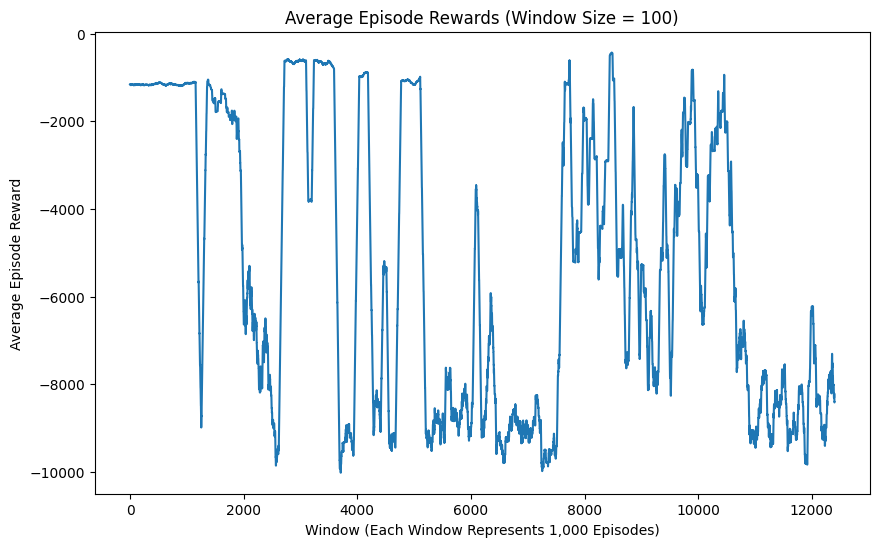

In [ ]:
episode_rewards = training_results.history['episode_reward']

window_size = 100
averages = [np.mean(episode_rewards[i:i+window_size]) for i in range(0, len(episode_rewards) - window_size + 1)]

plt.figure(figsize=(10, 6))
plt.plot(averages)
plt.title(f'Average Episode Rewards (Window Size = {window_size})')
plt.xlabel('Window (Each Window Represents 1,000 Episodes)')
plt.ylabel('Average Episode Reward')
plt.show()

The agent seems not able to maximize the reward. 

In [ ]:
results = dqn.test(env, nb_episodes=150, visualize=False)
print(np.mean(results.history['episode_reward']))

Testing for 150 episodes ...
Episode 1: reward: -672.715, steps: 8
Episode 2: reward: -176.709, steps: 8
Episode 3: reward: -383.048, steps: 8
Episode 4: reward: -1068.363, steps: 8
Episode 5: reward: -463.254, steps: 8
Episode 6: reward: -877.944, steps: 8
Episode 7: reward: -413.731, steps: 8
Episode 8: reward: -672.715, steps: 8
Episode 9: reward: -463.254, steps: 8
Episode 10: reward: -463.254, steps: 8
Episode 11: reward: -438.356, steps: 8
Episode 12: reward: -463.254, steps: 8
Episode 13: reward: -463.254, steps: 8
Episode 14: reward: -672.715, steps: 8
Episode 15: reward: -463.254, steps: 8
Episode 16: reward: -1068.363, steps: 8
Episode 17: reward: -672.715, steps: 8
Episode 18: reward: -463.254, steps: 8
Episode 19: reward: -202.154, steps: 8
Episode 20: reward: -877.944, steps: 8
Episode 21: reward: -1470.358, steps: 8
Episode 22: reward: -1271.476, steps: 8
Episode 23: reward: -226.779, steps: 8
Episode 24: reward: -463.254, steps: 8
Episode 25: reward: -672.715, steps: 8
E

### Testing EV Charging Environment
After training our policy, we now can test it and see the actions taken by the learnt policy.

In [ ]:
num_episodes = 900

for episode in range(num_episodes):
    learned_policy = []
    scores = 0
    state = env.reset()
    done = False
    battery_level = state[0]
    if episode % 100 == 0:
        print(f"Episode {episode + 1}: Initial battery level: {battery_level}") 

    while not done:
        state = np.expand_dims(state, axis=0)
        q_values = dqn.compute_q_values(state)  # Get Q-values from the DQN
        learned_action = np.argmax(q_values)  # Choose action with highest Q-value
        learned_policy.append(learned_action)
        state, reward, done, _ = env.step(learned_action)
        scores += reward
    if episode % 100 == 0:
        print(f"Episode {episode + 1}: Learned Policy: {learned_policy}")
        print(f"Episode {episode + 1}: Score: {scores}")

Episode 1: Initial battery level: 12.068861164076722
Episode 1: Learned Policy: [2, 2, 2, 2, 2, 2, 2, 3]
Episode 1: Score: -463.2539151915896
Episode 101: Initial battery level: 7.545750029298098
Episode 101: Learned Policy: [2, 2, 2, 2, 2, 3, 3, 3]
Episode 101: Score: -877.9438165904246
Episode 201: Initial battery level: 12.044466714295886
Episode 201: Learned Policy: [2, 2, 2, 2, 2, 2, 2, 3]
Episode 201: Score: -463.2539151915896
Episode 301: Initial battery level: 16.342343102066057
Episode 301: Learned Policy: [2, 1, 2, 2, 2, 2, 2, 3]
Episode 301: Score: -438.3555423443448
Episode 401: Initial battery level: 15.488987936076555
Episode 401: Learned Policy: [2, 1, 2, 2, 2, 2, 2, 3]
Episode 401: Score: -438.3555423443448
Episode 501: Initial battery level: 15.28196719894121
Episode 501: Learned Policy: [2, 1, 2, 2, 2, 2, 2, 3]
Episode 501: Score: -438.3555423443448
Episode 601: Initial battery level: 11.898352069981346
Episode 601: Learned Policy: [2, 2, 2, 2, 2, 2, 2, 3]
Episode 601

From these results we can obtain that the optimal charging policy is to avoid charging in the first two intervals. We know from the energy price market, that energy prices are high at this time. The agent uses the lower energy prices in the middle of the time period (around 3pm). The agent has also learnt to charge with a higher rate when the initial battery level is low. Therefore, it avoids that the vehicle runs out of energy.

A possible reason for the agent to charge with a high charging rate at the end of the episode is to avoid the penalty for running out of energy. Another reason could be the discount factor used in the calculation of the target Q-values. The discount factor makes the agent prioritize immediate rewards over delayed rewards.